In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Willson\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To create an embedding of a person's characteristics from an image that excludes the information about the clothing they are wearing, you can use a combination of techniques from computer vision and machine learning. Here's a step-by-step outline of the process:

Person Detection and Segmentation:

Use a person detection and segmentation model to isolate the person from the background and clothing. Models like Mask R-CNN or DeepLab can be used for this purpose.
Body Part Segmentation:

Further segment the person into different body parts (e.g., face, arms, legs) using a body part segmentation model. This helps in focusing on the body features without the clothing.
Feature Extraction:

Extract features from the segmented body parts using a pre-trained model like ResNet, VGG, or a specialized model for human body feature extraction.
Dimensionality Reduction and Embedding:

Use techniques like Principal Component Analysis (PCA) or an autoencoder to reduce the dimensionality of the extracted features and create a fixed-size embedding.
Here's an example implementation in Python using PyTorch:

1. Person Detection and Segmentation

## Pipeline

In [217]:
maskrcnn_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                        'bus', 'train', 'truck', 'boat', 'traffic light',
                        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                        'kite', 'baseball bat', 'baseball glove', 'skateboard',
                        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                        'teddy bear', 'hair drier', 'toothbrush']

'knife'

In [224]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import models
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mask_rcnn_model = maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn_model.eval()
body_part_model = deeplabv3_resnet101(pretrained=True)
body_part_model.eval()
resnet = models.resnet50(pretrained=True)
resnet.eval()

def person_detection_and_segmentation(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension and move to device
    
    print(image_tensor.shape)

    # Perform inference
    with torch.no_grad():
        predictions = mask_rcnn_model(image_tensor)
    print(np.array(predictions).shape)

    # Get the masks and boxes for the detected persons
    masks = predictions[0]['masks'].cpu().numpy()  # Move to CPU and convert to numpy
    boxes = predictions[0]['boxes'].cpu().numpy()  # Move to CPU and convert to numpy
    labels = predictions[0]['labels'].cpu().numpy()  # Move to CPU and convert to numpy
    print(labels)

    # Filter masks for person class (label 1) -> corresponding label names are found above
    # Turns out this model finds wrong things
    person_masks = [masks[i] for i in range(len(labels)) if labels[i] == 1]
    person_boxes = [boxes[i] for i in range(len(labels)) if labels[i] == 1]

    return person_masks, person_boxes, image_tensor

def body_part_segmentation(image, person_masks):
    segmented_body_parts = []
    for mask in person_masks:
        # Apply mask to the image
        mask = torch.tensor(mask).squeeze(0)  # Remove unnecessary dimensions and move to device
        person_image = image * mask

        # Perform body part segmentation
        with torch.no_grad():
            output = body_part_model(person_image)['out']
            segmented_body_parts.append(output.cpu().numpy())

    return segmented_body_parts

def extract_features(segmented_body_parts):
    features = []

    for body_part in segmented_body_parts:
        body_part_tensor = torch.tensor(body_part)
        body_part_tensor = body_part_tensor.permute(1, 0, 2, 3)     # [batch size, 1 (greyscale), imgH, imgW]
        
        # 3 RGB channels for resnet input
        body_part_tensor = body_part_tensor.repeat(1, 3, 1, 1)

        # Perform feature extraction
        with torch.no_grad():
            feature = resnet(body_part_tensor)
            features.append(feature.cpu().numpy())

    return features

def dimensionality_reduction(features):
    features = np.concatenate(features, axis=0)
    pca = PCA(n_components=features.shape[0])
    reduced_features = pca.fit_transform(features)
    return reduced_features

def get_person_embedding(image_path):
    person_masks, person_boxes, image_tensor = person_detection_and_segmentation(image_path)
    segmented_body_parts = body_part_segmentation(image_tensor, person_masks)
    features = extract_features(segmented_body_parts)
    embedding = dimensionality_reduction(features)
    # print("Person masks: ", person_masks)
    # print("Image tensor: ", image_tensor)
    # print("Segmented body parts: ", segmented_body_parts)
    # print("Features are: ", features)

    return embedding, features, segmented_body_parts, person_masks

# Usage
# image_path = 'c:/Users/Willson/Documents/shouldiwearit/data/fashionpedia/test/1f4c2d7ddfaa4d7c5a88df6d04ec0512.jpg'
image_path = 'c:/Users/Willson/Documents/shouldiwearit/data/fashionpedia/test/0a72e0f76ab9b75945f5d610508f9336.jpg'
embedding, features, segmented_body_parts, person_masks = get_person_embedding(image_path)
print(f'Embedding shape: {embedding.shape}')

c:\Users\Willson\anaconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Willson\anaconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Willson\anaconda3\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You

torch.Size([1, 3, 224, 224])
(1,)
[ 3  1 14  3 10  3  1]
Embedding shape: (42, 42)


#### Evaluation
1. Visualisation on OG image
2. Classification ?
3. Clustering ?

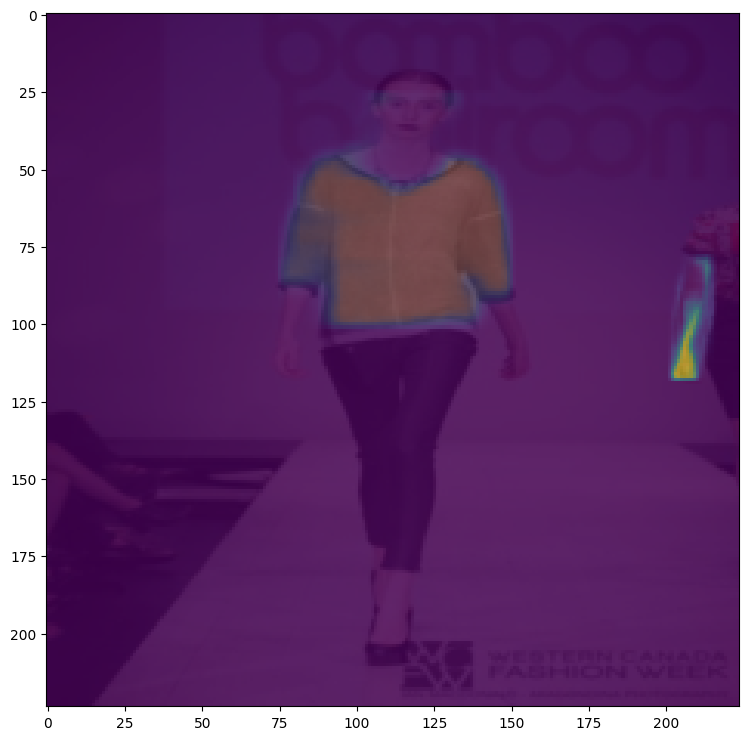

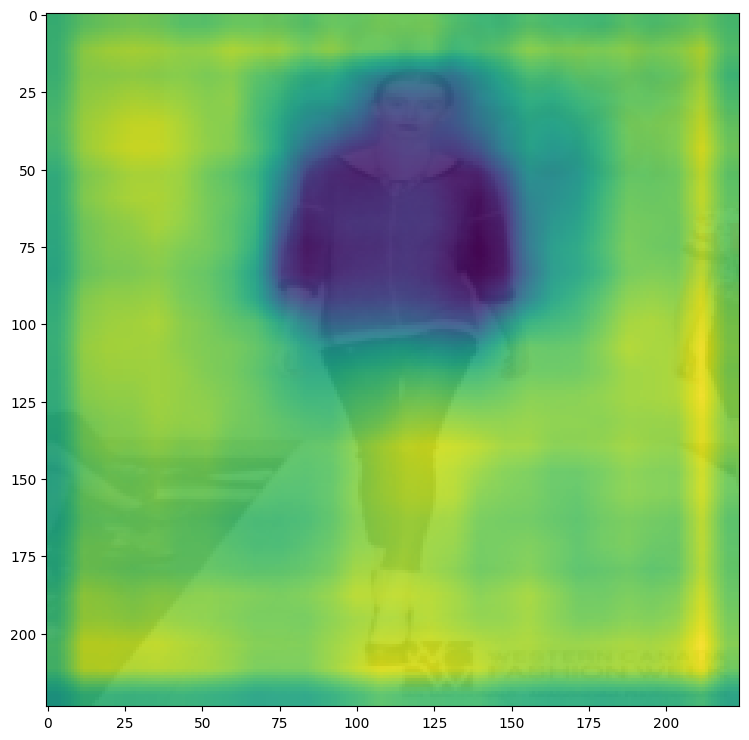

In [222]:
image = Image.open(image_path).convert('RGB')
transform_resize = transforms.Resize(size=(224, 224))
image_resized = transform_resize(image)

# 1. Person detection - person_masks
if True:
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image_resized)
    for mask in person_masks:
        mask = mask.squeeze()
        ax.imshow(mask, alpha=0.6)
    plt.show()

# 2. Body part segmentation - segmented_body_parts
# cluttered heat map
if True:
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image_resized)
    body_parts = segmented_body_parts[0][0]
    ax.imshow(body_parts[0], alpha=0.9)
    # for body_part in body_parts:
    #     ax.imshow(body_part, alpha=0.1)
    plt.show()

In [213]:
# Clustering to evaluate human dimensions
# Likely would just be same poses? -> no real information given on actual sizes
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load all images
directory = 'c:/Users/Willson/Documents/shouldiwearit/data/fashionpedia/test'
images = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Create embeddings
for image in images:
    image_path = os.path.join(directory, image)
    embedding, features, segmented_body_parts, person_masks = get_person_embedding(image_path)

# Clustering
def evaluate_clustering(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    print(f'Silhouette Score for {num_clusters} clusters: {silhouette_avg}')
    return cluster_labels

# # Example usage
# num_clusters = 5
# cluster_labels = evaluate_clustering(human_embeddings, num_clusters)


torch.Size([1, 3, 224, 224])
[ 3  3  3  3 14 44  3 10 44  3 44 14]
[]


ValueError: need at least one array to concatenate

# ViT for human embedding

### 1. Cleaning images
- Remove background
- Give person t-shirt and jeans

https://github.com/minar09/cp-vton-plus -> struggles with bottoms

Custom images need to be engineered first:
- 

#### Prompt

https://github.com/lllyasviel/ControlNet

- Works decent to put generic t-shirt and jeans on an image
- Find a way to do it for all -> multi-images
- Use **gradio_pose2image.py**